### Урок3. Связь бизнес-показателей и DS-метрик

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import itertools

In [2]:
res = pd.DataFrame(index=['logreg', 'forest', 'boost'], columns=['precision', 'recall', 'fscore', 'roc_auc'])

In [3]:
df = pd.read_csv('train_case2.csv', ';', index_col='id')
df.head(3)

c:\dev\geekbrains\venv\lib\site-packages\IPython\core\interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], test_size=0.3, random_state=13)

C:\Users\COSMOT~1\AppData\Local\Temp/ipykernel_2320/2951257381.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


In [5]:
y_train.value_counts()

1    24528
0    24472
Name: cardio, dtype: int64

In [6]:
y_test.value_counts()

0    10549
1    10451
Name: cardio, dtype: int64

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [7]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]] if self.key!='age' else X[[self.key]]//365
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]
    
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]//365


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))
    
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

In [8]:
class CardioModel():
    def __init__(self, model_type,params):
        self.classifier = Pipeline([
            ('features', feats),
            ('classifier', GridSearchCV(model_type,param_grid=params, scoring='roc_auc'))
            ])    
        
    def fit(self, X, y):
        #обучим пайплайн на всем тренировочном датасете
        self.classifier.fit(X, y)
        
    def predict(self, X):
        y_score = self.classifier.predict_proba(X)[:, 1]
        return y_score

In [9]:
def metrics(y_test, y_score, model, return_thres=False):
    b=0.95
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    res.loc[model,['precision','recall','fscore']] = [precision[ix],recall[ix],fscore[ix]]
    res.loc[model,'roc_auc']=roc_auc_score(y_true=y_test, y_score=y_score)
    print("roc auc score: {}".format(res.loc[model,'roc_auc']))
    if return_thres:
        return thresholds[ix]

def plot_roc_auc(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure(figsize=(10, 8))
    font = {'size' : 15}
    plt.rc('font', **font)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## LogisticRegression

In [11]:
params = {'max_iter':[100,200,500]}
model = CardioModel(LogisticRegression(random_state=42),params)
model.fit(X_train, y_train)
y_score = model.predict(X_test)
threshold = metrics(y_test, y_score, 'logreg', True)

Best Threshold=0.416514, F-Score=0.725, Precision=0.662, Recall=0.809
roc auc score: 0.778743031855052


Confusion matrix, without normalization
[[6234 4315]
 [1997 8454]]


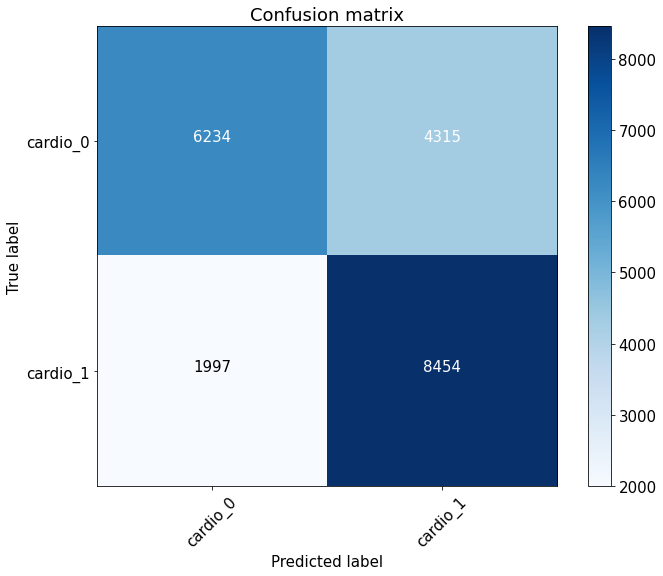

In [12]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
cnf_matrix = confusion_matrix(y_test, y_score>threshold)
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")


In [13]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8089178069084298, 0.40904351123329225, 0.5909564887667077)

## RandomForest

In [14]:
params = {'n_estimators':range(5,31,5), 'max_depth':range(5,15,2)}
model = CardioModel(RandomForestClassifier(random_state=42), params)
model.fit(X_train, y_train)
y_score = model.predict(X_test)
threshold = metrics(y_test, y_score, 'forest', True)

Best Threshold=0.397287, F-Score=0.736, Precision=0.691, Recall=0.794
roc auc score: 0.7981089275241268


Confusion matrix, without normalization
[[6829 3720]
 [2152 8299]]


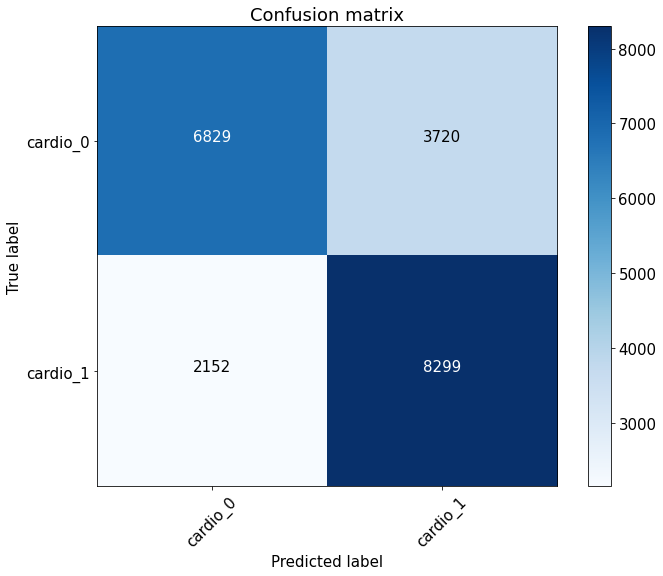

In [15]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
cnf_matrix = confusion_matrix(y_test, y_score>threshold)
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')

In [16]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.7940866902688738, 0.35264006066925774, 0.6473599393307422)

## AdaBoost

In [17]:
params = {'n_estimators':range(5,41,5), 'learning_rate': [0.5, 0.75, 1]}
model = CardioModel(AdaBoostClassifier(random_state=42), params)
model.fit(X_train, y_train)
y_score = model.predict(X_test)
threshold = metrics(y_test, y_score, 'boost', True)

Best Threshold=0.496317, F-Score=0.731, Precision=0.671, Recall=0.811
roc auc score: 0.7904932786790214


Confusion matrix, without normalization
[[6393 4156]
 [1982 8469]]


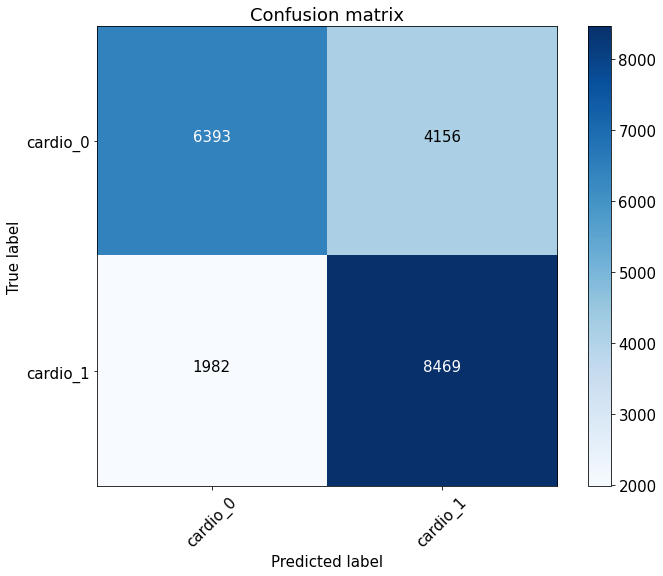

In [18]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
cnf_matrix = confusion_matrix(y_test, y_score>threshold)
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')

In [19]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8103530762606449, 0.3939709925111385, 0.6060290074888615)

## Результаты

In [20]:
res

,precision,recall,fscore,roc_auc
logreg,0.662099,0.809013,0.724512,0.778743
forest,0.690516,0.794182,0.736096,0.798109
boost,0.670811,0.810544,0.730556,0.790493


В качестве скоринга для кросс-валидации была взята метрика roc_auc, для выбора порога - fscore с $\beta$=0.95. Лес показал наиболее сбалансированный результат по всем метрикам. Бустинг дает схожий результат, увеличивая долю прогнозов класса 1, что приводит к росту recall, но падению precision за счет роста FP. Регрессия немного менее точна, однако учится в разы быстрее. Во всех трех моделях наблюдается проблема гипердиагностики, слишком высокого FPR (который по возможности мы пытались нивелировать при помощи $\beta$).

## Дополнительно

*Какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:*

*Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:*

* *первая помечает 100 объектов как класс 1, но TP = 90*
* *вторая помечает 1000 объектов как класс 1, но TP такой же - 90*

*Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?*

Для несбалансированной выборки - precision_recall, т.к. из-за существенного перевеса в 0 классе FPR будет не сильно меняться в описанных двух случаях, тогда как для второй по оси precision будут серьезные изменения (из-за высокого количества FP относитьльно TP). Лучше, естественно, первая модель.